 # Assignment 5.2 - ( 5.1, 5.2, & 6.1)

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

Exercise 5.1: In the BRFSS (see Section 5.4), the distribution of heights is roughly normal with parameters µ = 178 cm and σ = 7.7 cm for men, and µ = 163 cm and σ = 7.3 cm for women.

In order to join Blue Man Group, you have to be male between 5’10” and 6’1” (see http://bluemancasting.com). What percentage of the U.S. male population is in this range? Hint: use scipy.stats.norm.cdf.

scipy.stats contains objects that represent analytic distributions

In [1]:
import scipy.stats

For example scipy.stats.norm represents a normal distribution.

In [3]:
mu = 178
sigma = 7.7
dist = scipy.stats.norm(loc=mu, scale=sigma)
type(dist)

scipy.stats._distn_infrastructure.rv_frozen

A "frozen random variable" can compute its mean and standard deviation.

In [4]:
dist.mean(), dist.std()

(178.0, 7.7)

It can also evaluate its CDF. How many people are below the mean by more than one standard deviation? About 16%

In [5]:
dist.cdf(mu - sigma)

0.1586552539314574

How many people are between 5'10" and 6'1"?

In [6]:
dist.cdf(mu + sigma)

0.8413447460685426

^ According to this (where I added one standard deviation to the mean), 84% of people fall between 5'10 and 6'1

Exercise 5.2: To get a feel for the Pareto distribution, let’s see how different the world would be if the distribution of human height were Pareto. With the parameters xm = 1 m and α = 1.7, we get a distribution with a reasonable minimum, 1 m, and median, 1.5 m.

Plot this distribution. What is the mean human height in Pareto world? What fraction of the population is shorter than the mean? If there are 7 billion people in Pareto world, how many do we expect to be taller than 1 km? How tall do we expect the tallest person to be?

scipy.stats.pareto represents a pareto distribution. In Pareto world, the distribution of human heights has parameters alpha=1.7 and xmin=1 meter. So the shortest person is 100 cm and the median is 150.

In [33]:
alpha = 1.7
xmin = 1  # meter
dist = scipy.stats.pareto(b=alpha, scale=xmin)
dist.mean()

2.428571428571429

What is the mean height in Pareto world?

In [22]:
print("This is the mean in meters: ", dist.mean())
print("This is the mean in feet: ", (dist.mean()) * 3.281)
print("This is the mean in inches: ", (dist.mean()) * 39.3701)
print("This is the mean in centimeters: ", (dist.mean()) * 100)

This is the mean in meters:  2.428571428571429
This is the mean in feet:  7.968142857142858
This is the mean in inches:  95.61310000000002
This is the mean in centimeters:  242.8571428571429


What fraction of people are shorter than the mean?

In [42]:
import numpy

import thinkstats2
import thinkplot

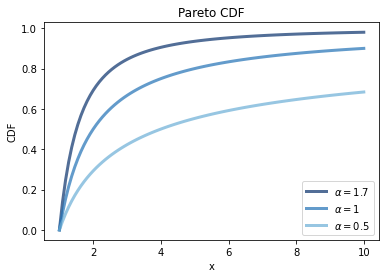

In [43]:
thinkplot.PrePlot(3)
for alpha in [1.7, 1.0, 0.5]:
    xs, ps = thinkstats2.RenderParetoCdf(xmin, alpha, 0, 10.0, n=100)
    thinkplot.Plot(xs, ps, label=r"$\alpha=%g$" % alpha)

thinkplot.Config(title="Pareto CDF", xlabel="x", ylabel="CDF", loc="lower right")

In [51]:
dist.cdf(dist.mean())

0.778739697565288

Out of 7 billion people, how many do we expect to be taller than 1 km? You could use dist.cdf or dist.sf.

In [54]:
(1 - dist.cdf(1000)) * 7e9, dist.sf(1000) * 7e9

(55602.976430479954, 55602.97643069972)

How tall do we expect the tallest person to be?

In [55]:
dist.sf(600000) * 7e9

1.0525455861201714

# Chapter 6¶
Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

### Exercises
The distribution of income is famously skewed to the right. In this exercise, we’ll measure how strong that skew is. The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded hinc06.xls, which is an Excel spreadsheet with information about household income, and converted it to hinc06.csv, a CSV file you will find in the repository for this book. You will also find hinc2.py, which reads this file and transforms the data.

The dataset is in the form of a series of income ranges and the number of respondents who fell in each range. The lowest range includes respondents who reported annual household income “Under  5000.”𝑇ℎ𝑒ℎ𝑖𝑔ℎ𝑒𝑠𝑡𝑟𝑎𝑛𝑔𝑒𝑖𝑛𝑐𝑙𝑢𝑑𝑒𝑠𝑟𝑒𝑠𝑝𝑜𝑛𝑑𝑒𝑛𝑡𝑠𝑤ℎ𝑜𝑚𝑎𝑑𝑒“ 250,000 or more.”

To estimate mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range. hinc2.py provides InterpolateSample, which shows one way to model this data. It takes a DataFrame with a column, income, that contains the upper bound of each range, and freq, which contains the number of respondents in each frame.

It also takes log_upper, which is an assumed upper bound on the highest range, expressed in log10 dollars. The default value, log_upper=6.0 represents the assumption that the largest income among the respondents is  106 , or one million dollars.

InterpolateSample generates a pseudo-sample; that is, a sample of household incomes that yields the same number of respondents in each range as the actual data. It assumes that incomes in each range are equally spaced on a log10 scale

In [58]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [59]:
import numpy as np

import thinkstats2
import thinkplot

In [70]:
import brfss

df = brfss.ReadBrfss(nrows=None)

## Moments

Raw moments are just sums of powers.

In [80]:
def RawMoment(xs, k):
    return sum(x**k for x in xs) / len(xs)

The first raw moment is the mean. The other raw moments don't mean much.

In [82]:
def Mean(xs):
    return RawMoment(xs, 1)

The central moments are powers of distances from the mean.

In [83]:
def CentralMoment(xs, k):
    mean = RawMoment(xs, 1)
    return sum((x - mean)**k for x in xs) / len(xs)

The first central moment is approximately 0. The second central moment is the variance.

In [84]:
def Var(xs):
    return CentralMoment(xs, 2)

The standardized moments are ratios of central moments, with powers chosen to make the dimensions cancel.

In [85]:
def StandardizedMoment(xs, k):
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    return CentralMoment(xs, k) / std**k

The third standardized moment is skewness.

In [86]:
def Skewness(xs):
    return StandardizedMoment(xs, 3)

In [87]:
def Median(xs):
    cdf = thinkstats2.Cdf(xs)
    return cdf.Value(0.5)

Because the skewness is based on the third moment, it is not robust; that is, it depends strongly on a few outliers. Pearson's median skewness is more robust.

In [88]:
def PearsonMedianSkewness(xs):
    median = Median(xs)
    mean = RawMoment(xs, 1)
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    gp = 3 * (mean - median) / std
    return gp

In [89]:
def InterpolateSample(df, log_upper=6.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, int(row.freq))
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample


In [90]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc06.csv")

In [91]:
import hinc
income_df = hinc.ReadData()

In [92]:
log_sample = InterpolateSample(income_df, log_upper=6.0)

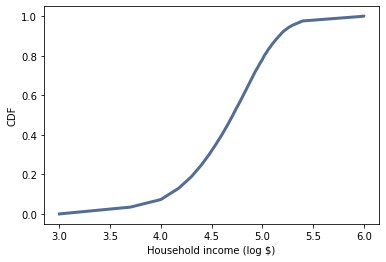

In [93]:
log_cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(log_cdf)
thinkplot.Config(xlabel='Household income (log $)',
               ylabel='CDF')

In [94]:
sample = np.power(10, log_sample)

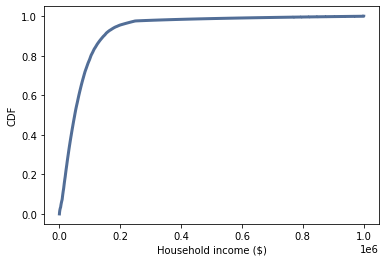

In [95]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)',
               ylabel='CDF')

Compute the median, mean, skewness and Pearson’s skewness of the resulting sample. What fraction of households report a taxable income below the mean? How do the results depend on the assumed upper bound?

In [97]:
Mean(sample), Median(sample)

(74278.70753118733, 51226.45447894046)

In [98]:
Skewness(sample), PearsonMedianSkewness(sample)

(4.949920244429583, 0.7361258019141782)

In [99]:
cdf.Prob(Mean(sample))

0.660005879566872

All of this is based on an assumption that the highest income is one million dollars, but that's certainly not correct. What happens to the skew if the upper bound is 10 million?

Without better information about the top of this distribution, we can't say much about the skewness of the distribution.

In [100]:
def InterpolateSample(df, log_upper=7.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, int(row.freq))
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample
# log of ten million is 7.0

In [101]:
log_sample = InterpolateSample(income_df, log_upper=7.0)

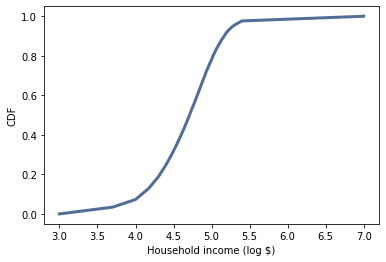

In [102]:
log_cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(log_cdf)
thinkplot.Config(xlabel='Household income (log $)',
               ylabel='CDF')

In [103]:
sample = np.power(10, log_sample)

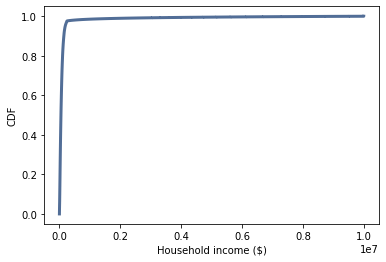

In [104]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)',
               ylabel='CDF')

In [105]:
Skewness(sample), PearsonMedianSkewness(sample)

(11.603690267537793, 0.39156450927742087)

The skewness increases drastically from about 4 to about 11.